In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

import utils

In [2]:
file_path = "../data/filtered_g_patent.csv"

patent_data = pd.read_csv(file_path)

C:\Users\HP\AppData\Local\Temp\ipykernel_15288\1232075052.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  patent_data = pd.read_csv(file_path)


In [3]:
patent_data

patent_id            patent_type patent_date  \
0       10000025                utility  2018-06-19   
1       10000026                utility  2018-06-19   
2       10000036                utility  2018-06-19   
3       10000050                utility  2018-06-19   
4       10000300                utility  2018-06-19   
...          ...                    ...         ...   
124283   T102103  defensive publication  1982-08-03   
124284   T958004  defensive publication  1977-05-03   
124285   T967003  defensive publication  1978-02-07   
124286   T967009  defensive publication  1978-02-07   
124287   T988007  defensive publication  1979-11-06   

                                             patent_title  \
0       Optimized cross-ply orientation in composite l...   
1       Composite induction consolidation apparatus an...   
2       High kinetic energy penetrator shielding and h...   
3       Method for the manufacture of a fibre composit...   
4       Device for holding and aligning a useful compo...   
...                                                   ...   
124283            Surge arrester insulating spacer device   
124284  Hot-melt adhesive, and wood composite structur...   
124285                 Flooring of wood-plastic composite   
124286  Method of applying a wear-resistant composite ...   
124287  Laser deposition of metal upon transparent mat...   

                                          patent_abstract wipo_kind  \
0       A composite laminate has a primary axis of loa...        B2   
1       A composite induction consolidation apparatus ...        B2   
2       Boron nitride nanotubes (BNNTs), boron nitride...        B2   
3       A method for the manufacture of a fiber compos...        B2   
4       A device for holding and aligning a component ...        B2   
...                                                   ...       ...   
124283                                                NaN        I4   
124284                                                NaN        I4   
124285                                                NaN        I4   
124286                                                NaN        I4   
124287                                                NaN        I4   

        num_claims  withdrawn                 filename     Time  \
0                9          0            ipg180619.xml  2018-06   
1               18          0            ipg180619.xml  2018-06   
2               20          0            ipg180619.xml  2018-06   
3                3          0            ipg180619.xml  2018-06   
4               14          0            ipg180619.xml  2018-06   
...            ...        ...                      ...      ...   
124283           8          0  pftaps19820803_wk31.zip  1982-08   
124284           6          0  pftaps19770503_wk18.zip  1977-05   
124285           1          0  pftaps19780207_wk06.zip  1978-02   
124286           5          0  pftaps19780207_wk06.zip  1978-02   
124287           5          0  pftaps19791106_wk45.zip  1979-11   

                         Week  
0       2018-06-18/2018-06-24  
1       2018-06-18/2018-06-24  
2       2018-06-18/2018-06-24  
3       2018-06-18/2018-06-24  
4       2018-06-18/2018-06-24  
...                       ...  
124283  1982-08-02/1982-08-08  
124284  1977-05-02/1977-05-08  
124285  1978-02-06/1978-02-12  
124286  1978-02-06/1978-02-12  
124287  1979-11-05/1979-11-11  

[124288 rows x 11 columns]

In [4]:
patent_data.dtypes

patent_id          object
patent_type        object
patent_date        object
patent_title       object
patent_abstract    object
wipo_kind          object
num_claims          int64
withdrawn           int64
filename           object
Time               object
Week               object
dtype: object

In [5]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [6]:
patent_data['cleaned_title'] = patent_data['patent_title'].apply(utils.clean_text)
title_list = patent_data['cleaned_title'].tolist()

In [7]:
# g_patent_title_embeddings = model.encode(patent_data['cleaned_title'].tolist())

In [8]:
import pickle

# Load the embeddings
with open('./pickle/g_patent_title_embeddings.pkl', 'rb') as f:
    g_patent_title_embeddings = pickle.load(f)

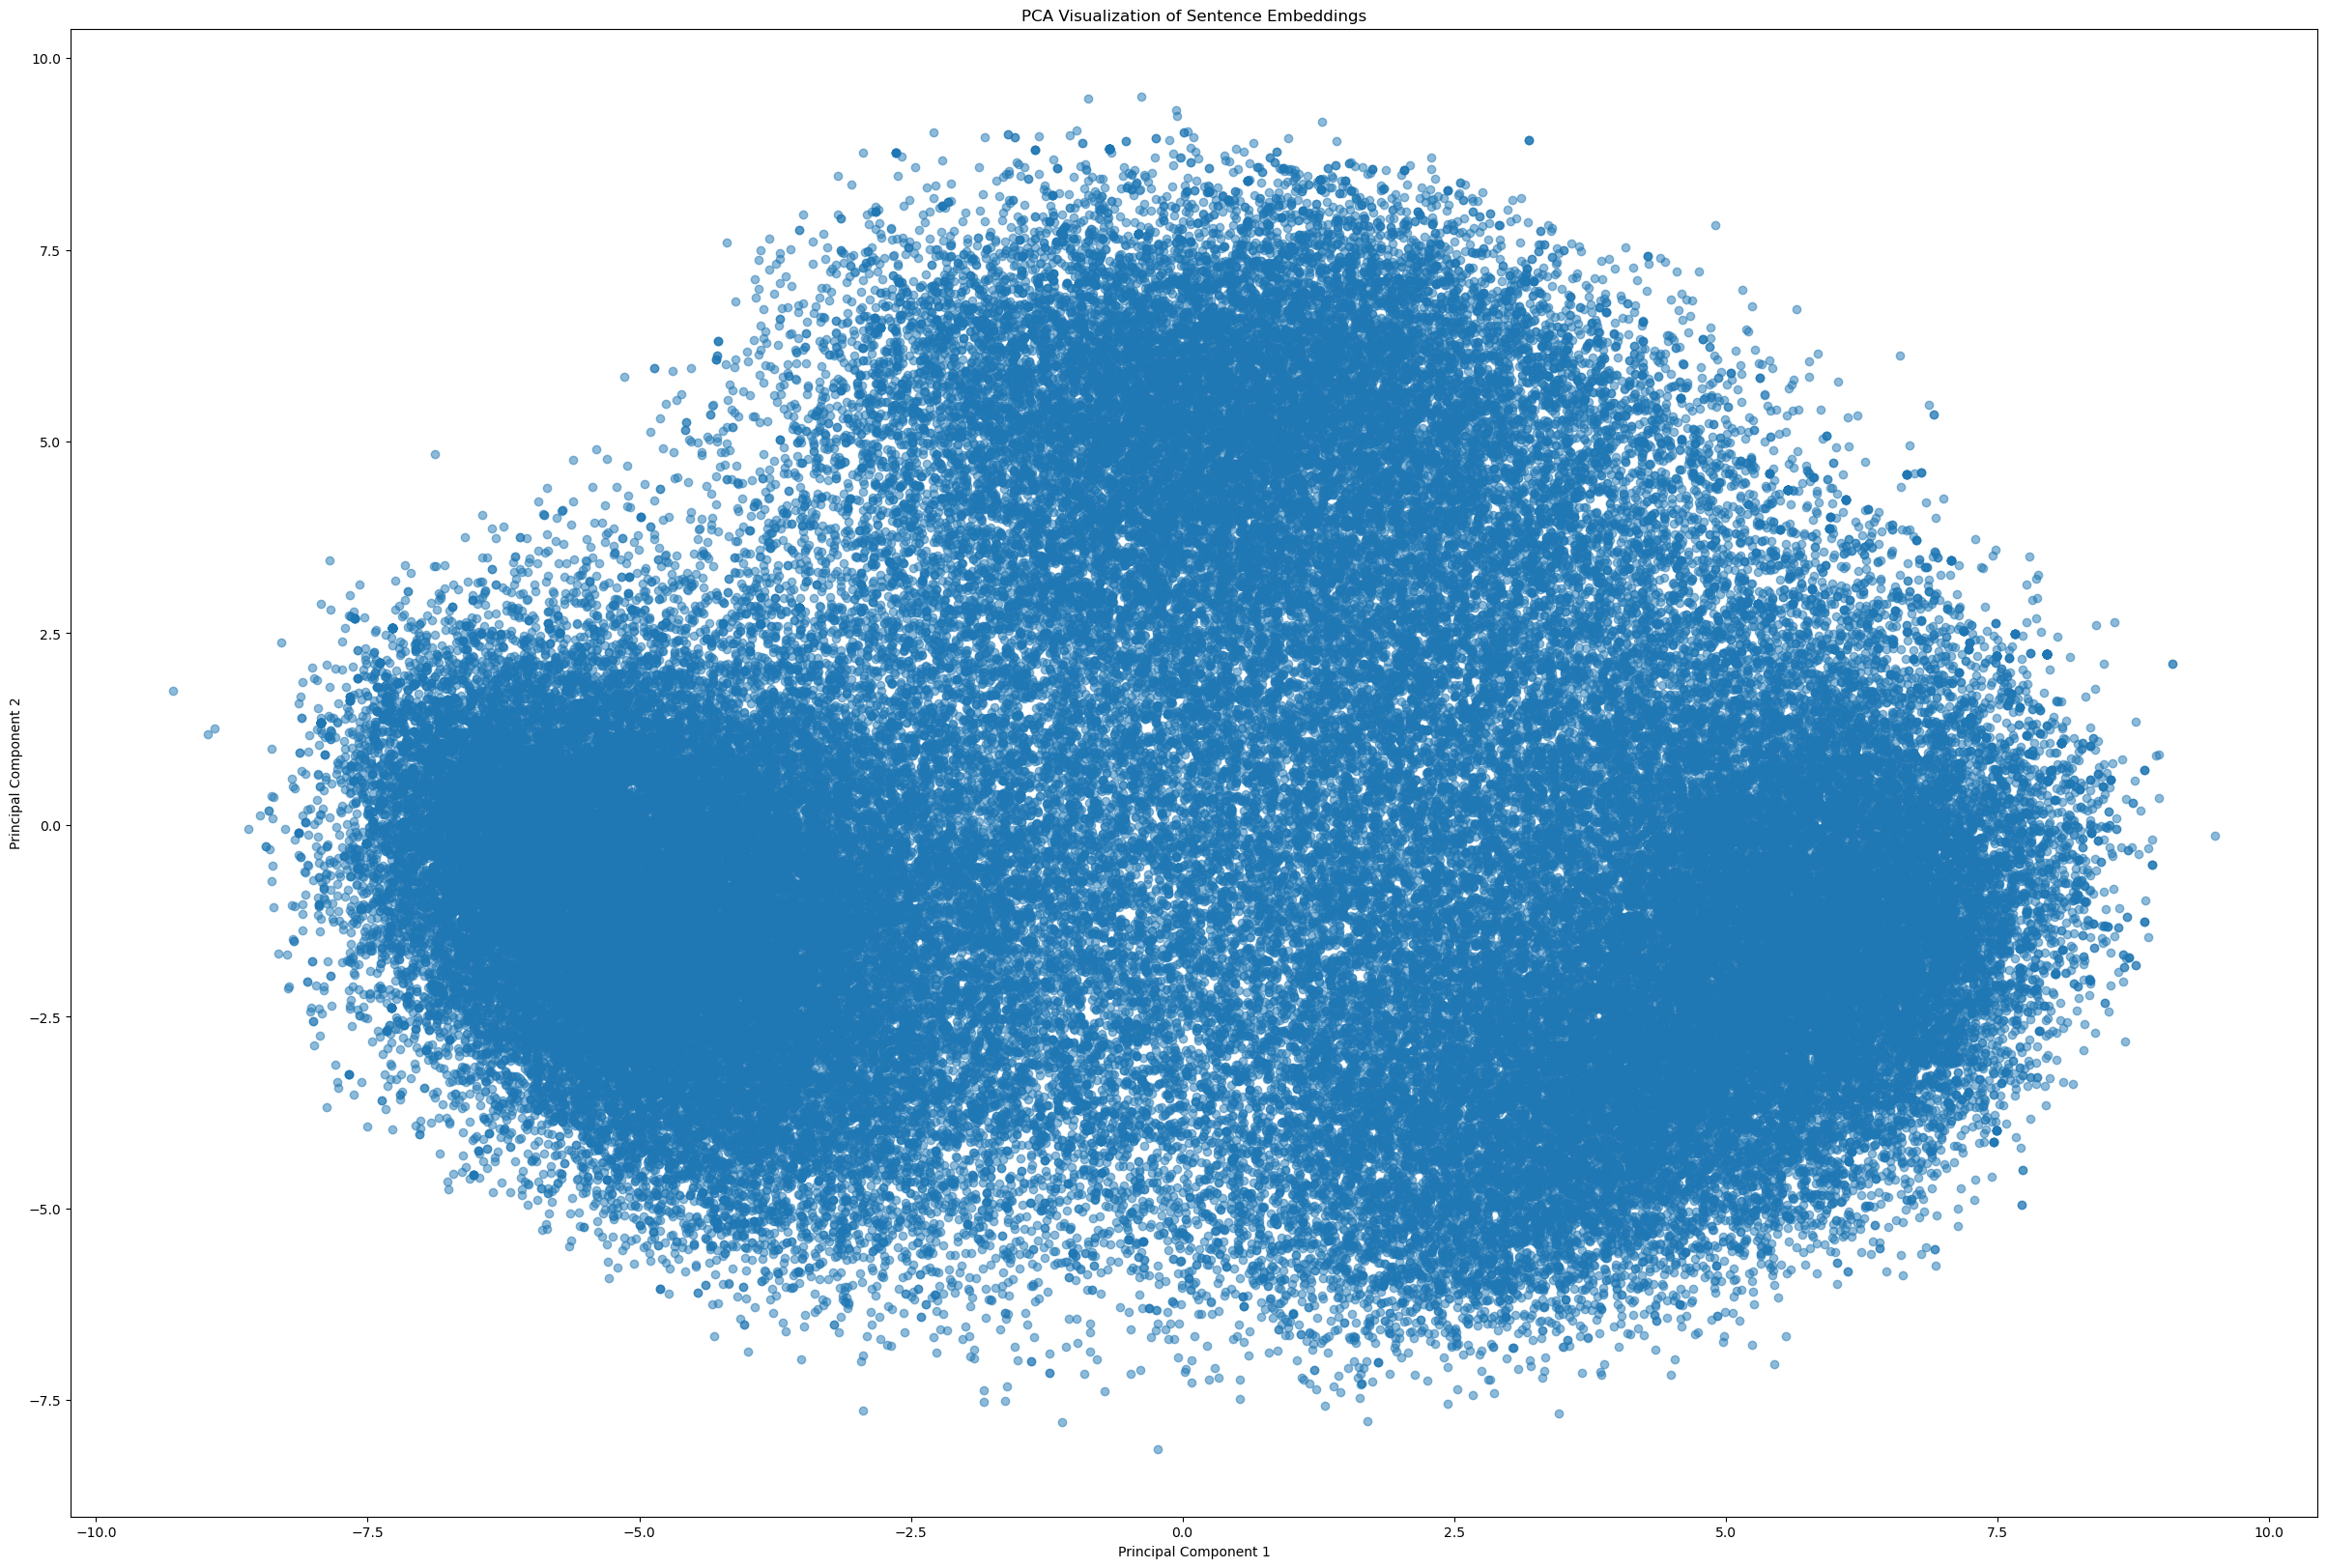

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA to reduce dimensionality
pca = PCA(n_components=2)
title_embeddings_pca = pca.fit_transform(g_patent_title_embeddings)

# t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
title_embeddings_tsne = tsne.fit_transform(g_patent_title_embeddings)

# Plot the embeddings with a larger figure size
plt.figure(figsize=(30, 20))
plt.scatter(title_embeddings_pca[:, 0], title_embeddings_pca[:, 1], alpha=0.5)
plt.title("PCA Visualization of Sentence Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

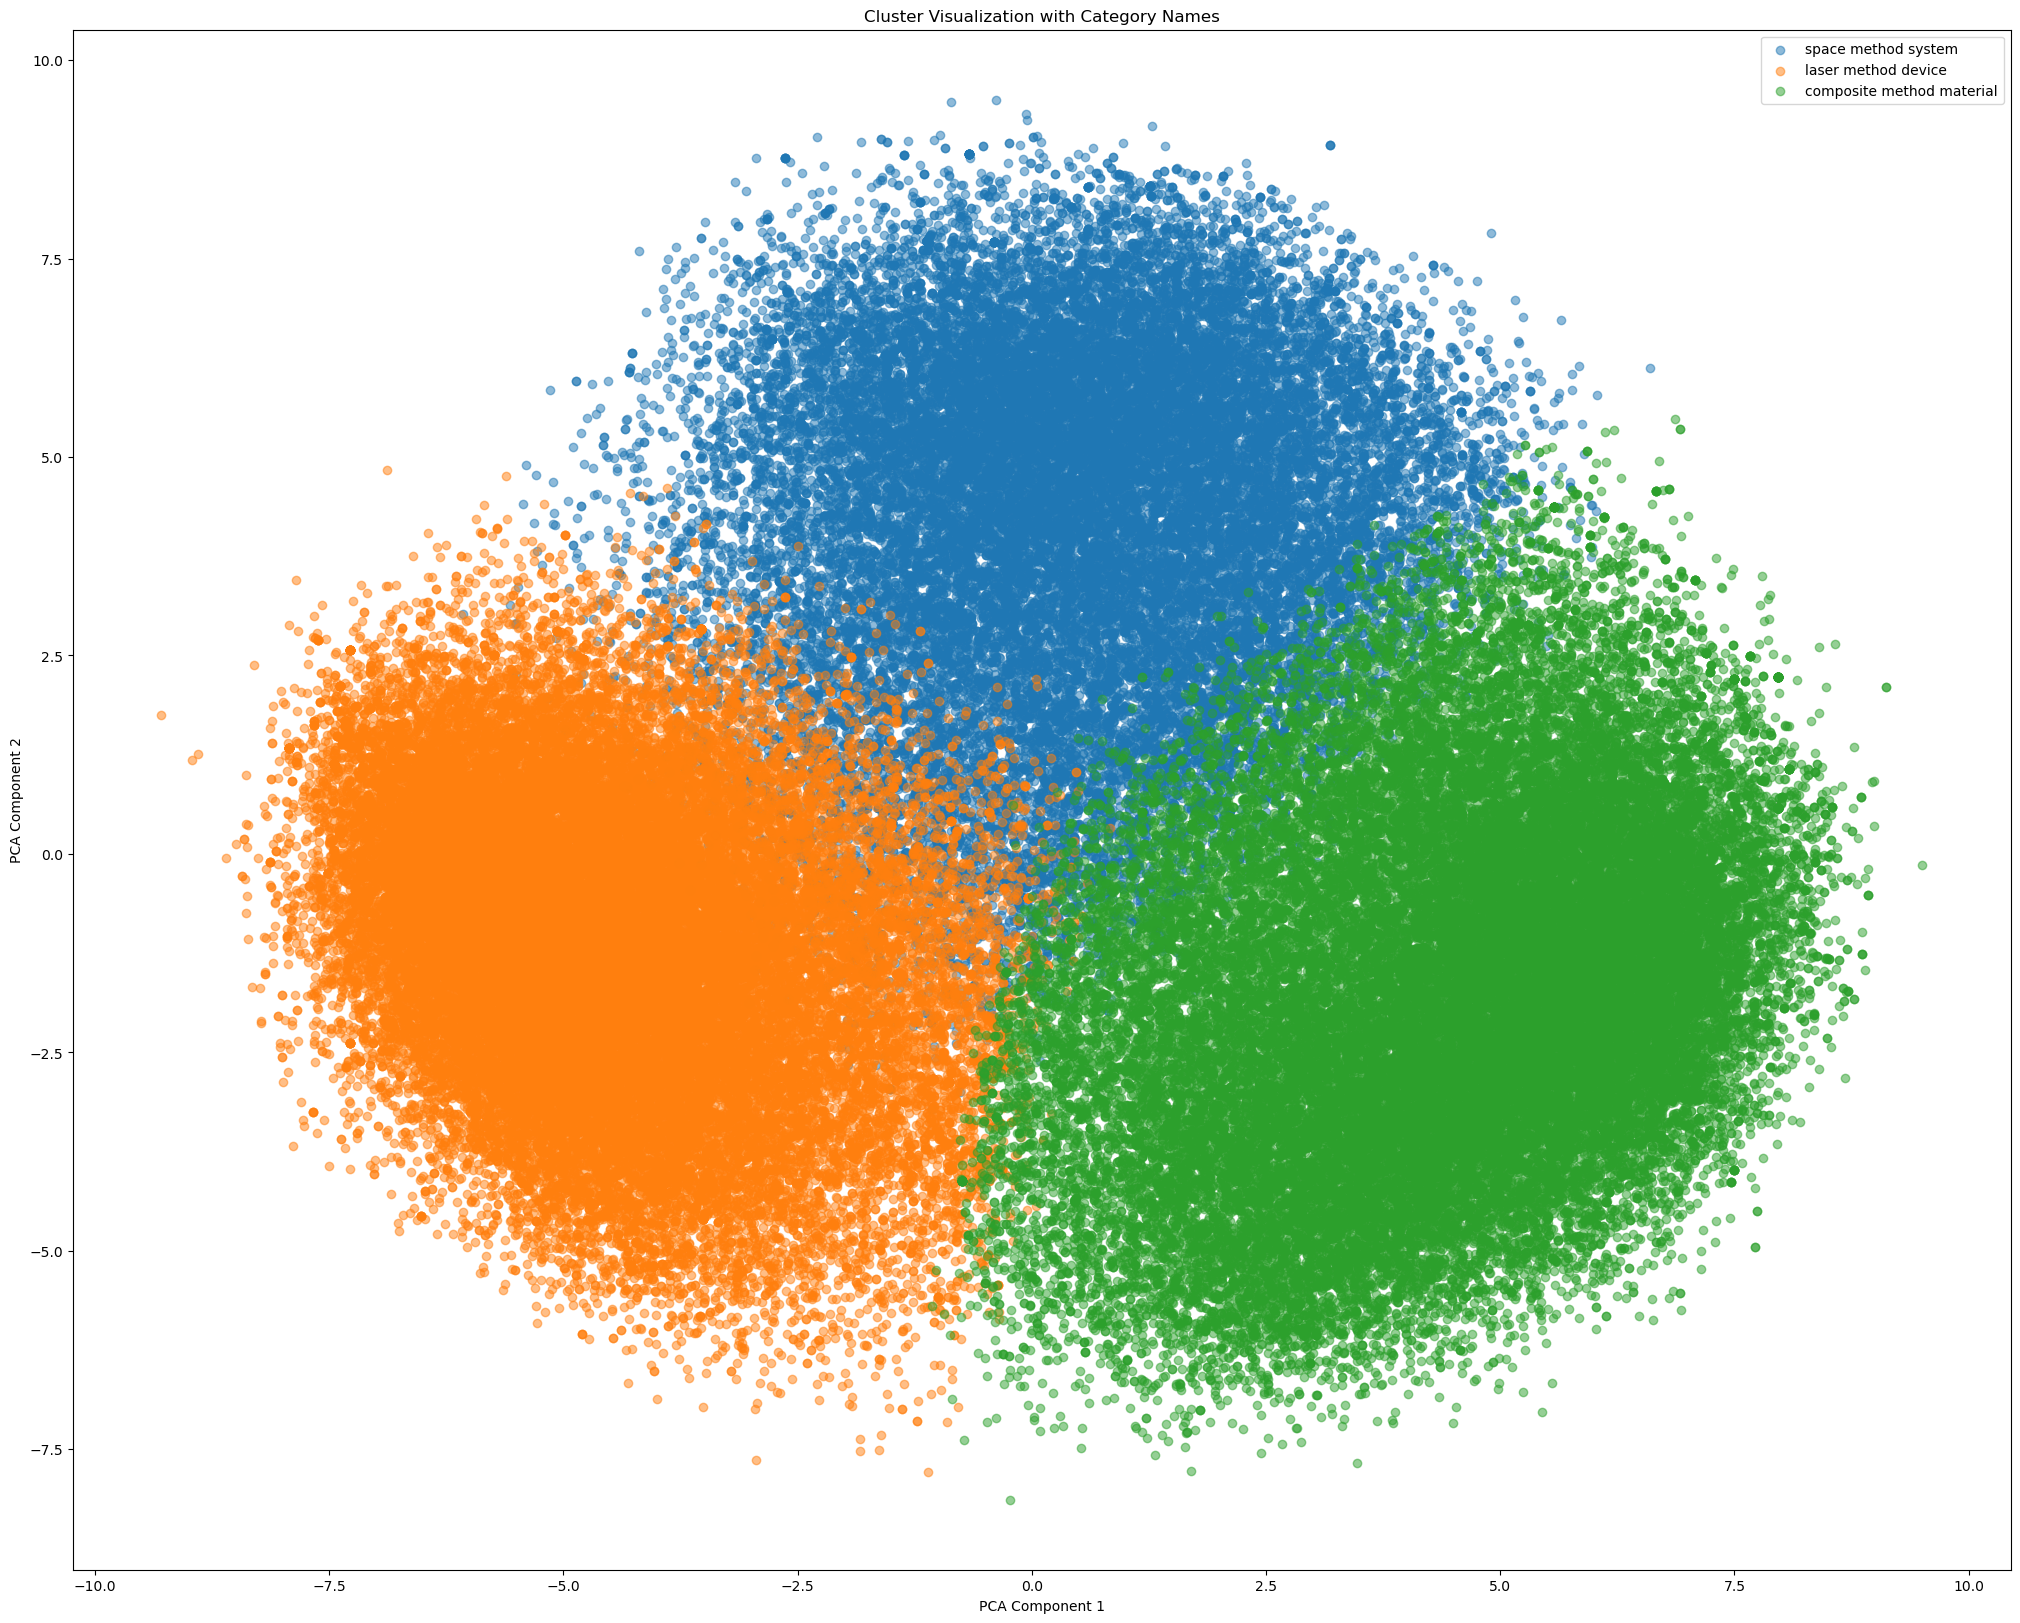

In [20]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from nltk.corpus import stopwords

# Step 1: Cluster the embedded text
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k)
cluster_labels = kmeans.fit_predict(g_patent_title_embeddings)

# Step 2: Assign category names to clusters based on topic modeling
cluster_names = {}
stop_words = list(stopwords.words('english'))  # Convert English stop words to a list
for cluster_id in range(k):
    # Extract titles in the current cluster
    titles_in_cluster = np.array(title_list)[cluster_labels == cluster_id]
    
    # Use CountVectorizer to convert text into a matrix of token counts
    vectorizer = CountVectorizer(stop_words=stop_words)
    X = vectorizer.fit_transform(titles_in_cluster)
    
    # Use Latent Dirichlet Allocation (LDA) for topic modeling
    lda = LatentDirichletAllocation(n_components=1, random_state=42)
    lda.fit(X)
    
    # Get the most probable words in the topics
    feature_names = vectorizer.get_feature_names_out()
    topic_words_idx = lda.components_[0].argsort()[-3:][::-1]
    topic_words = [feature_names[i] for i in topic_words_idx]
    
    # Join the top words to form the category name
    category_name = ' '.join(topic_words)
    cluster_names[cluster_id] = category_name

# Step 3: Visualize the clusters with category names
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
title_embeddings_2d = pca.fit_transform(g_patent_title_embeddings)

# Plot the clusters
plt.figure(figsize=(25, 20))
for cluster_id in range(k):
    plt.scatter(title_embeddings_2d[cluster_labels == cluster_id, 0], 
                title_embeddings_2d[cluster_labels == cluster_id, 1], 
                label=cluster_names[cluster_id], alpha=0.5)
plt.title("Cluster Visualization with Category Names")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [82]:
query = 'unmanned aerial vehicle'
query_embedding = model.encode([query])
number_top_matches = 100000

print("Relevant Patents using Semantic Search:")
relevant_patents_df = utils.semantic_search(query, query_embedding, g_patent_title_embeddings, patent_data, threshold=0.6, top_matches=number_top_matches,
                                      patent_id_col='Patent ID', pub_number_col='patent_id',
                                      title_col='patent_title', abstract_col='patent_abstract',
                                      date_col='patent_date', cpc_col='wipo_kind')

relevant_patents_df

Relevant Patents using Semantic Search:


Patent ID     Score patent_id  \
0         13743  0.842871  10909861   
1        116333  0.809686   9613535   
2        119785  0.795303   9858822   
3         29063  0.780705  11855387   
4           360  0.780245  10023329   
...         ...       ...       ...   
3507       8072  0.600178  10538343   
3508      23336  0.600161  11514765   
3509      26850  0.600142  11724831   
3510      26835  0.600085  11724393   
3511     124281  0.600070   T100604   

                                           patent_title  \
0        Unmanned aerial vehicle in controlled airspace   
1     Method for allowing missions of unmanned aeria...   
2     Airspace activity tracking using unmanned aeri...   
3     Plug-in assembly structure and an unmanned aer...   
4                                  Space vehicle system   
...                                                 ...   
3507  Vertical take-off and landing spacecraft and m...   
3508  Systems and methods for spatial sensing and tr...   
3509  Electromagnetic spacetime continuum propulsion...   
3510  Robotic arm space position adjustment method, ...   
3511  Method of placing a spacecraft into final eart...   

                                        patent_abstract patent_date wipo_kind  
0     A method performed by an unmanned aerial vehic...  2021-02-02        B2  
1     A method for allowing missions of unmanned aer...  2017-04-04        B2  
2     This disclosure is directed to an automated un...  2018-01-02        B1  
3     A plug-in assembly structure for a UAV include...  2023-12-26        B2  
4     A space launch vehicle includes a first sectio...  2018-07-17        B1  
...                                                 ...         ...       ...  
3507  A vertical take-off and landing spacecraft inc...  2020-01-21        B2  
3508  This disclosure is directed to product display...  2022-11-29        B2  
3509  An electromagnetic propulsion system for the m...  2023-08-15        B2  
3510  The present disclosure provides a robotic arm ...  2023-08-15        B2  
3511                                                NaN  1981-05-05        I4  

[3512 rows x 7 columns]

In [83]:
print("Number of Relevant Patents:", len(relevant_patents_df))

Number of Relevant Patents: 3512


In [84]:
import pandas as pd
import matplotlib.pyplot as plt

def rank_top_wipo_kind_codes(relevant_patents_df, wipo_kind_col):
    # Filter rows where 'WIPO Kind' column is not null and not empty
    relevant_patents_df = relevant_patents_df.dropna(subset=[wipo_kind_col])
    relevant_patents_df = relevant_patents_df[relevant_patents_df[wipo_kind_col] != '']

    # Count the frequency of each WIPO kind code
    wipo_kind_counts = relevant_patents_df[wipo_kind_col].value_counts()

    # Rank the top 5 WIPO kind codes
    top_wipo_kind_codes = wipo_kind_counts.head(5)

    return top_wipo_kind_codes

# Example usage:
top_wipo_kind_codes = rank_top_wipo_kind_codes(relevant_patents_df, 'wipo_kind')

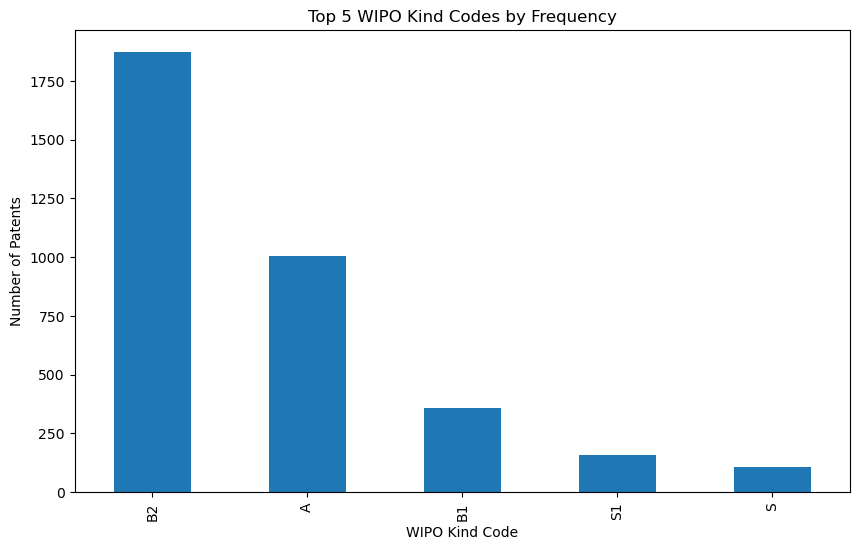

In [85]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
top_wipo_kind_codes.plot(kind='bar')
plt.xlabel('WIPO Kind Code')
plt.ylabel('Number of Patents')
plt.title('Top 5 WIPO Kind Codes by Frequency')
plt.show()

In [86]:
relevant_patents_df = utils.preprocess_date_column(relevant_patents_df, 'patent_date')

For Code B2: Estimated Parameters (a, b, c): [ 3.16177316e+03 -1.77521003e+00  1.72919483e+03]


C:\Users\HP\AppData\Local\Temp\ipykernel_20612\1203552715.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(growth_model, cumulative_counts.index, cumulative_counts, p0=initial_guess)


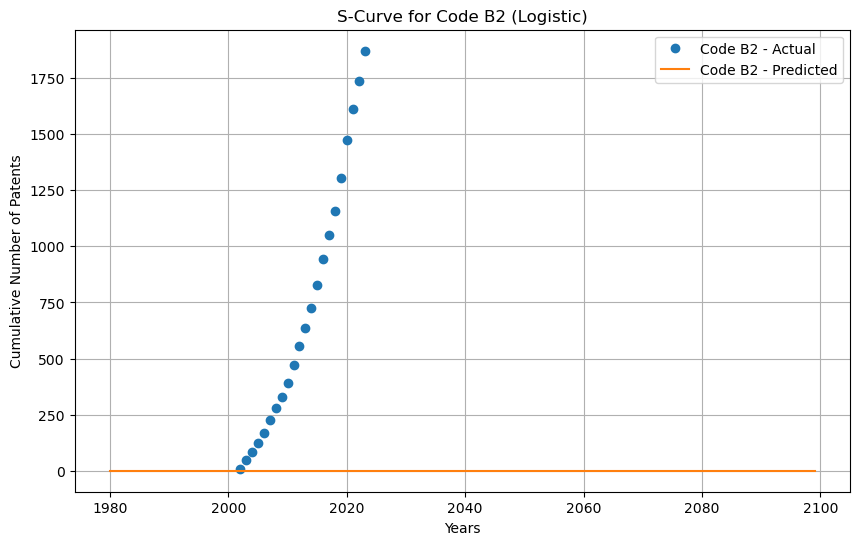

For Code A: Estimated Parameters (a, b, c): [1.26173944e+03 1.65993553e-01 1.99442728e+03]


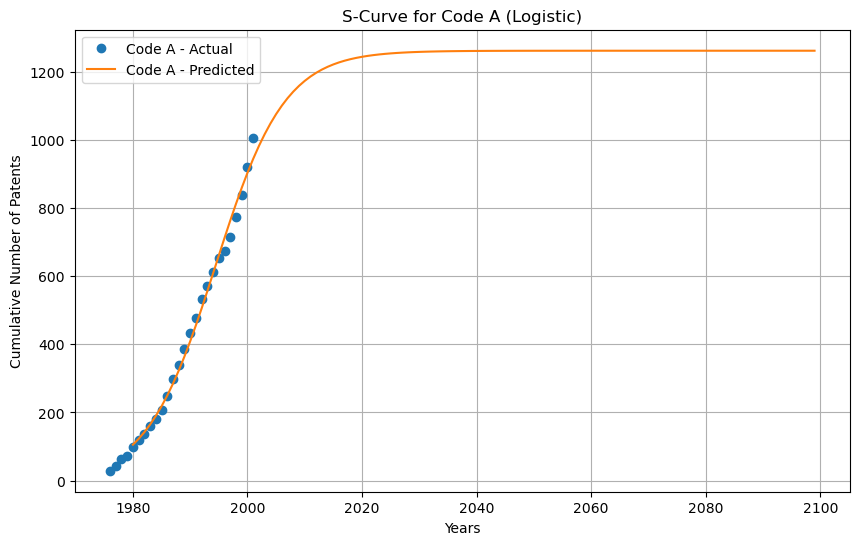

For Code B1: Estimated Parameters (a, b, c): [5.86851931e+03 5.56687569e-02 2.07210484e+03]


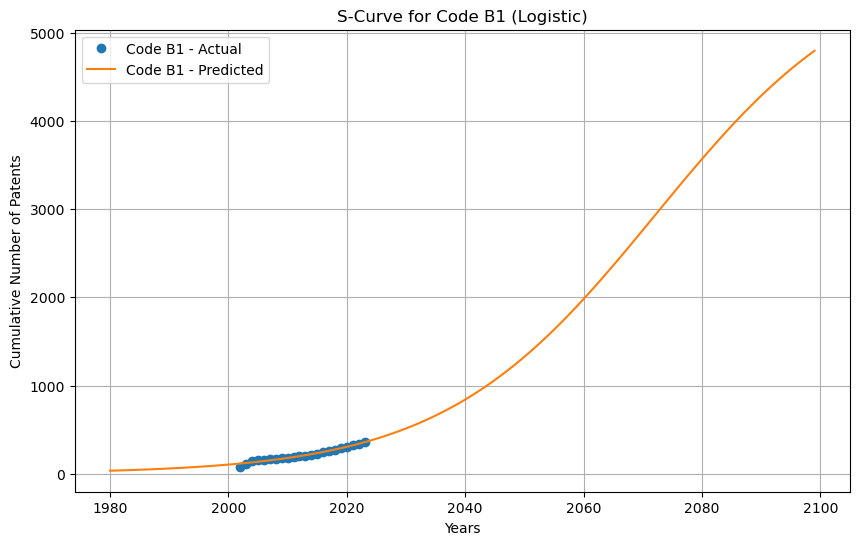

For Code S1: Estimated Parameters (a, b, c): [ 2.71733701e+02 -1.66074498e+00  1.75594163e+03]


C:\Users\HP\AppData\Local\Temp\ipykernel_20612\1203552715.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(growth_model, cumulative_counts.index, cumulative_counts, p0=initial_guess)


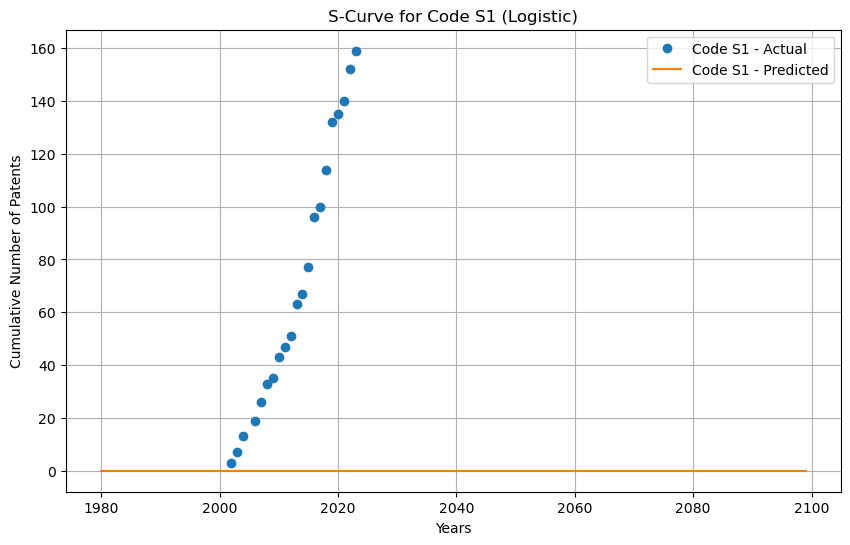

For Code S: Estimated Parameters (a, b, c): [5.67313567e+02 6.41249949e-02 2.02508659e+03]


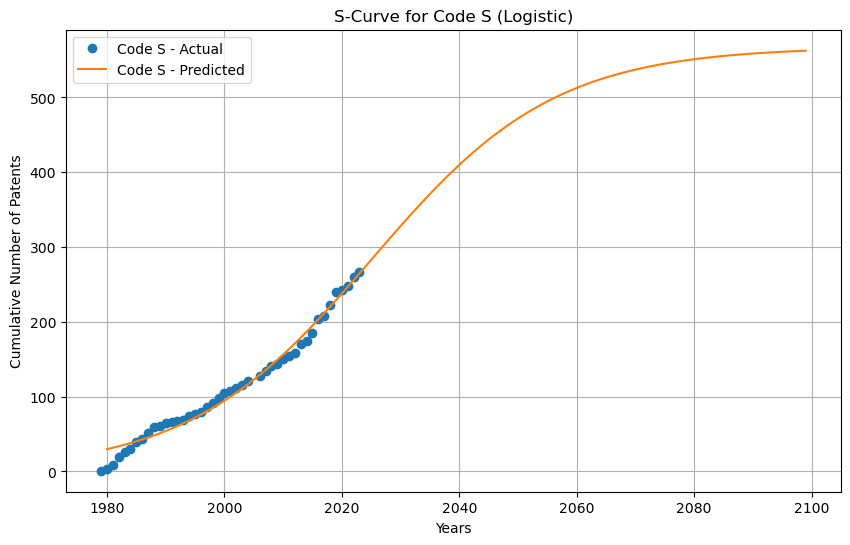

In [87]:
from scipy.optimize import curve_fit

def plot_s_curves(relevant_patents_df, code_counts, code_col, time_col, top_n=5, year_range=(1990, 2070), growth_model=None, growth_model_label=None):
    if growth_model is None or growth_model_label is None:
        raise ValueError("Both growth_model and growth_model_label must be specified.")
    
    top_codes = code_counts.head(top_n).index
    
    for code in top_codes:
        code_relevant_patents = relevant_patents_df[relevant_patents_df[time_col].notna() & relevant_patents_df[code_col].str.contains(code)]
        year_counts = code_relevant_patents.groupby(code_relevant_patents[time_col].dt.year).size()
        
        if not year_counts.empty:
            future_years = np.arange(*year_range)
            cumulative_counts = year_counts.cumsum()

            try:
                initial_guess = (max(cumulative_counts), 0.1, year_range[0])
                popt, pcov = curve_fit(growth_model, cumulative_counts.index, cumulative_counts, p0=initial_guess)
                future_counts = growth_model(future_years, *popt)

                print(f"For Code {code}: Estimated Parameters (a, b, c): {popt}")

                plt.figure(figsize=(10, 6))
                plt.plot(year_counts.index, cumulative_counts, 'o', label=f'Code {code} - Actual')
                if future_years is not None and future_counts is not None:
                    plt.plot(future_years, future_counts, label=f'Code {code} - Predicted')

                plt.xlabel('Years')
                plt.ylabel('Cumulative Number of Patents')
                plt.title(f'S-Curve for Code {code} ({growth_model_label})')
                plt.legend()
                plt.grid(True)
                plt.show()
            except RuntimeError:
                print(f"Failed to fit {growth_model_label} growth model for Code {code}")
        else:
            print(f"No data available for Code {code}")

# Example usage:
plot_s_curves(relevant_patents_df, top_wipo_kind_codes, 'wipo_kind', 'patent_date', top_n=5, year_range=(1980, 2100), growth_model=utils.logistic_growth, growth_model_label="Logistic")